In [1]:
!pip install blitz-bayesian-pytorch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 1.3 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings('ignore')


In [3]:
import matplotlib.pyplot as plt
import math
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator
from torch.utils.data import TensorDataset, DataLoader
from matplotlib.pyplot import scatter, figure
from scipy import stats
from numpy.ma.core import outer
from sys import stderr


In [4]:
start = -7
end = 7
n = 300
batch_size = 16

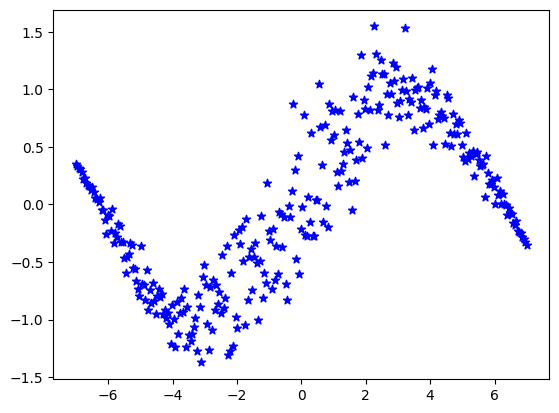

In [5]:
def sample_dataset(start, end, n):
    np.random.seed(0)
    x = np.linspace(start, end, n)
    sample_mean = [math.sin(i/2) for i in x]

    sample_var = [abs((abs(start)+abs(end))/2 - abs(i))/16 for i in x]
    y = stats.norm(sample_mean, sample_var).rvs(random_state=0)
    return x, y

x_train, y_train = sample_dataset(start, end, n)
scatter(x_train, y_train, c="blue", marker="*")

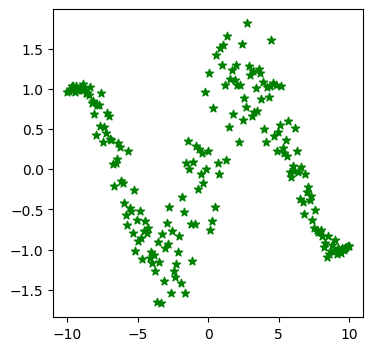

In [6]:
figure(figsize=(4, 4))
# Not exactely the same distribution, but works for now
x_test, y_test = sample_dataset(-10, 10, 200)
scatter(x_test, y_test, c="green", marker="*")

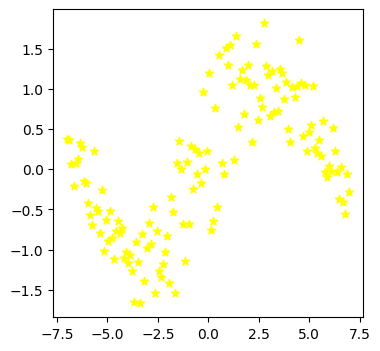

In [7]:
#Plotting In Training Distribution Data Points in the Test Set
# Filter the data to retain only the desired ranges
mask =  (x_test >= -7) &  (x_test <= 7) # Select the ranges -10 to -7 and 7 to 10
x_test_idd = x_test[mask]
y_test_idd = y_test[mask]

plt.figure(figsize=(4, 4))
plt.scatter(x_test_idd, y_test_idd, c="yellow", marker="*")

plt.show()


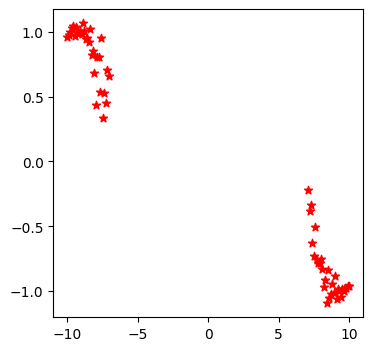

In [8]:
#Plotting Out of Training Distribution Data Points in the Test Set
# Filter the data to retain only the desired ranges
mask = (x_test >= -10) & (x_test < -7) | (x_test > 7) & (x_test <= 10) # Select the ranges -10 to -7 and 7 to 10
x_test_oodd = x_test[mask]
y_test_oodd = y_test[mask]

plt.figure(figsize=(4, 4))
plt.scatter(x_test_oodd, y_test_oodd, c="red", marker="*")

plt.show()


In [9]:

# Train
tensor_x = torch.Tensor(x_train).unsqueeze(1)
tensor_y = torch.Tensor(y_train).unsqueeze(1)
train_dataset = TensorDataset(tensor_x, tensor_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#Test for OODD (Out of Data Distribution)
tensor_x_test_oodd = torch.Tensor(x_test_oodd).unsqueeze(1)
tensor_y_test_oodd = torch.Tensor(y_test_oodd).unsqueeze(1)
test_dataset_oodd = TensorDataset(tensor_x_test_oodd, tensor_y_test_oodd)
test_loader_oodd = DataLoader(test_dataset_oodd, batch_size=batch_size, shuffle=True)

#Test for IDD (In Data Distribution)
tensor_x_test_idd = torch.Tensor(x_test_idd).unsqueeze(1)
tensor_y_test_idd = torch.Tensor(y_test_idd).unsqueeze(1)
test_dataset_idd = TensorDataset(tensor_x_test_idd, tensor_y_test_idd)
test_loader_idd = DataLoader(test_dataset_idd, batch_size=batch_size, shuffle=True)

# Test
tensor_x_test = torch.Tensor(x_test).unsqueeze(1)
tensor_y_test = torch.Tensor(y_test).unsqueeze(1)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [10]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        hidden_size = 60

        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.mu = nn.Linear(hidden_size, 1)
        self.var = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        h = torch.relu(self.fc2(h))
        mu = self.mu(h)
        var = torch.exp(self.var(h))
        return mu, var

model = SimpleNet()
print(model)
print("Params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

SimpleNet(
  (fc1): Linear(in_features=1, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=60, bias=True)
  (mu): Linear(in_features=60, out_features=1, bias=True)
  (var): Linear(in_features=60, out_features=1, bias=True)
)
Params: 3902


In [11]:
def make_plot_de(model):
    mus = []
    vars = []
    for m in model:
        mu, var = m(tensor_x_test)
        mus.append(mu)
        vars.append(var)

    # For epistemic uncertainty we calculate the std on the mus!
    # Arash: note how vars is no longer used in evaluation
    means = torch.stack(mus).mean(axis=0).detach().numpy()
    stds = torch.stack(mus).std(axis=0).detach().numpy()**(1/2)

    dfs = []
    y_vals = [means, means+2*stds, means-2*stds]

    for i in range(3):
      data = {
            "x": list(tensor_x_test.squeeze().numpy()),
            "y": list(y_vals[i].squeeze())
      }
      temp = pd.DataFrame.from_dict(data)
      dfs.append(temp)

    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot test data on top
    scatter(x_test, y_test, c="green", marker="*", alpha=0.1)

    plt.show()

In [25]:
def make_plot_de_oodd(model):
    mus = []
    vars = []
    for m in model:
        mu, var = m(tensor_x_test_oodd)
        mus.append(mu)
        vars.append(var)

    # For epistemic uncertainty we calculate the std on the mus!
    # Arash: note how vars is no longer used in evaluation
    means = torch.stack(mus).mean(axis=0).detach().numpy()
    stds = torch.stack(mus).std(axis=0).detach().numpy()**(1/2)

    dfs = []
    y_vals = [means, means+2*stds, means-2*stds]

    for i in range(3):
      data = {
            "x": list(tensor_x_test_oodd.squeeze().numpy()),
            "y": list(y_vals[i].squeeze())
      }
      temp = pd.DataFrame.from_dict(data)
      dfs.append(temp)

    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot test data on top
    scatter(x_test_oodd, y_test_oodd, c="red", marker="*", alpha=0.1)

    plt.show()

In [26]:
def make_plot_de_idd(model):
    mus = []
    vars = []
    for m in model:
        mu, var = m(tensor_x_test_idd)
        mus.append(mu)
        vars.append(var)

    # For epistemic uncertainty we calculate the std on the mus!
    # Arash: note how vars is no longer used in evaluation
    means = torch.stack(mus).mean(axis=0).detach().numpy()
    stds = torch.stack(mus).std(axis=0).detach().numpy()**(1/2)

    dfs = []
    y_vals = [means, means+2*stds, means-2*stds]

    for i in range(3):
      data = {
            "x": list(tensor_x_test_idd.squeeze().numpy()),
            "y": list(y_vals[i].squeeze())
      }
      temp = pd.DataFrame.from_dict(data)
      dfs.append(temp)

    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot test data on top
    scatter(x_test_idd, y_test_idd, c="yellow", marker="*", alpha=0.1)

    plt.show()

In [14]:
# Construct ensemble
num_models = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
deep_ensemble = [SimpleNet().to(device) for i in range(num_models)]
criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
optimizers = [optim.Adam(m.parameters(), lr=0.001) for m in deep_ensemble]

In [15]:
def denn():
  # Construct ensemble
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  num_models = 5
  deep_ensemble = [SimpleNet().to(device) for i in range(num_models)]
  criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
  optimizers = [optim.Adam(m.parameters(), lr=0.001) for m in deep_ensemble]
  for epoch in range(150):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)

        losses = []
        mus = []
        vars = []
        for i, model in enumerate(deep_ensemble):
            optimizers[i].zero_grad()
            mu, var = model(x)
            loss = criterion(mu, y, var)
            loss.backward()
            optimizers[i].step()
            criterionmse_train = nn.MSELoss()
            mse_train = criterionmse_train(mu, y)
            losses.append(loss.item())
            mus.append(mu)
            vars.append(var)
        loss = sum(losses)/len(losses)

    if epoch % 10 == 0:
        all_test_losses = []
        all_mse_test=[]
        # Test loop
        for batch in test_loader:
            x = batch[0].to(device)
            y = batch[1].to(device)

            test_losses = []
            mus = []
            vars = []
            for i, model in enumerate(deep_ensemble):
                optimizers[i].zero_grad()
                mu, var = model(x)
                test_loss = criterion(mu, y, var)
                optimizers[i].step()

                test_losses.append(test_loss.item())
                mus.append(mu)
                vars.append(var)
            all_test_losses.append((sum(test_losses)/len(test_losses)))
            criterionmse_test = nn.MSELoss()
            all_mse_test.append(criterionmse_test(mu,y).item())
  test_loss = sum(all_test_losses)/len(all_test_losses)
  test_mse=sum(all_mse_test)/len(all_mse_test)
  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
  print(f"Epoch {epoch} |batch train mse:{mse_train}| test mse:{test_mse}")
  make_plot_de(deep_ensemble)
  return loss,test_loss,mse_train, test_mse


In [22]:
def denn_oodd():
  # Construct ensemble
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  num_models = 5
  deep_ensemble = [SimpleNet().to(device) for i in range(num_models)]
  criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
  optimizers = [optim.Adam(m.parameters(), lr=0.001) for m in deep_ensemble]
  for epoch in range(150):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)

        losses = []
        mus = []
        vars = []
        for i, model in enumerate(deep_ensemble):
            optimizers[i].zero_grad()
            mu, var = model(x)
            loss = criterion(mu, y, var)
            loss.backward()
            optimizers[i].step()
            criterionmse_train = nn.MSELoss()
            mse_train = criterionmse_train(mu, y)
            losses.append(loss.item())
            mus.append(mu)
            vars.append(var)
        loss = sum(losses)/len(losses)

    if epoch % 10 == 0:
        all_test_losses = []
        all_mse_test=[]
        # Test loop
        for batch in test_loader_oodd:
            x = batch[0].to(device)
            y = batch[1].to(device)

            test_losses = []
            mus = []
            vars = []
            for i, model in enumerate(deep_ensemble):
                optimizers[i].zero_grad()
                mu, var = model(x)
                test_loss = criterion(mu, y, var)
                optimizers[i].step()

                test_losses.append(test_loss.item())
                mus.append(mu)
                vars.append(var)
            all_test_losses.append((sum(test_losses)/len(test_losses)))
            criterionmse_test = nn.MSELoss()
            all_mse_test.append(criterionmse_test(mu,y).item())
  test_loss = sum(all_test_losses)/len(all_test_losses)
  test_mse=sum(all_mse_test)/len(all_mse_test)
  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
  print(f"Epoch {epoch} |batch train mse:{mse_train}| test mse:{test_mse}")
  make_plot_de_oodd(deep_ensemble)
  return loss,test_loss,mse_train, test_mse


In [23]:
def denn_idd():
  # Construct ensemble
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  num_models = 5
  deep_ensemble = [SimpleNet().to(device) for i in range(num_models)]
  criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
  optimizers = [optim.Adam(m.parameters(), lr=0.001) for m in deep_ensemble]
  for epoch in range(150):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)

        losses = []
        mus = []
        vars = []
        for i, model in enumerate(deep_ensemble):
            optimizers[i].zero_grad()
            mu, var = model(x)
            loss = criterion(mu, y, var)
            loss.backward()
            optimizers[i].step()
            criterionmse_train = nn.MSELoss()
            mse_train = criterionmse_train(mu, y)
            losses.append(loss.item())
            mus.append(mu)
            vars.append(var)
        loss = sum(losses)/len(losses)

    if epoch % 10 == 0:
        all_test_losses = []
        all_mse_test=[]
        # Test loop
        for batch in test_loader_idd:
            x = batch[0].to(device)
            y = batch[1].to(device)

            test_losses = []
            mus = []
            vars = []
            for i, model in enumerate(deep_ensemble):
                optimizers[i].zero_grad()
                mu, var = model(x)
                test_loss = criterion(mu, y, var)
                optimizers[i].step()

                test_losses.append(test_loss.item())
                mus.append(mu)
                vars.append(var)
            all_test_losses.append((sum(test_losses)/len(test_losses)))
            criterionmse_test = nn.MSELoss()
            all_mse_test.append(criterionmse_test(mu,y).item())
  test_loss = sum(all_test_losses)/len(all_test_losses)
  test_mse=sum(all_mse_test)/len(all_mse_test)
  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
  print(f"Epoch {epoch} |batch train mse:{mse_train}| test mse:{test_mse}")
  make_plot_de_idd(deep_ensemble)
  return loss,test_loss,mse_train, test_mse


Epoch 149 | batch train loss: -1.370844316482544 | test loss: 0.9490709614295224
Epoch 149 |batch train mse:0.050988029688596725| test mse:0.15999457927850577


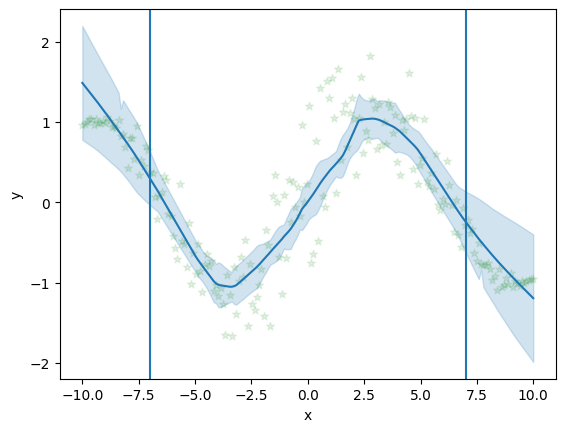

Epoch 149 | batch train loss: -1.4162882328033448 | test loss: 0.9459142418434987
Epoch 149 |batch train mse:0.0384453646838665| test mse:0.16055839909957006


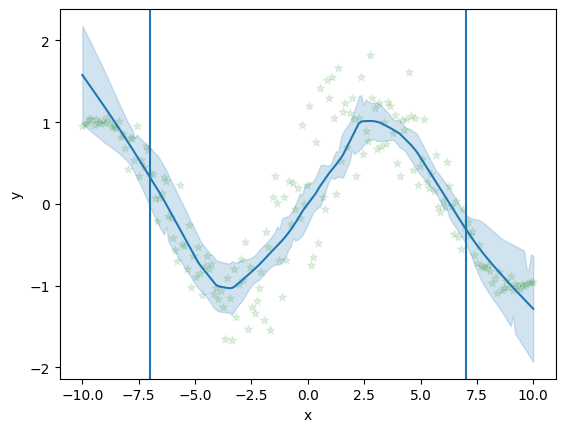

Epoch 149 | batch train loss: -1.1028002977371216 | test loss: 0.38455031829384656
Epoch 149 |batch train mse:0.07074923068284988| test mse:0.1444887054654268


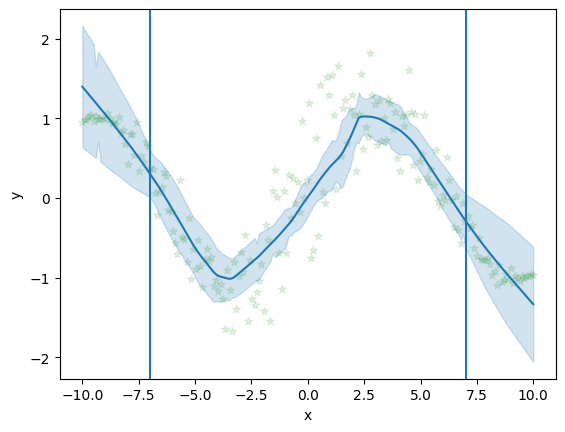

Epoch 149 | batch train loss: -1.1260311126708984 | test loss: 0.7345194829771151
Epoch 149 |batch train mse:0.08028003573417664| test mse:0.18026391989909685


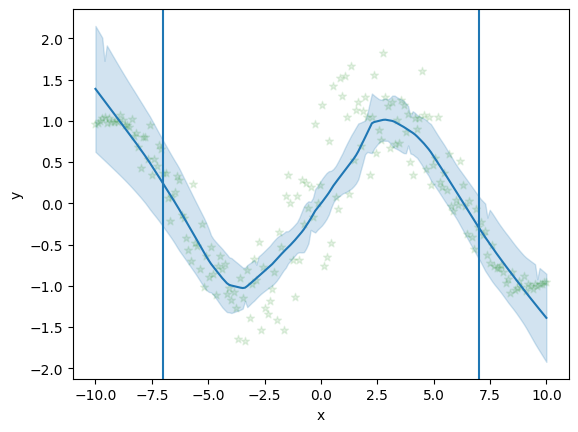

Epoch 149 | batch train loss: -1.2570096254348755 | test loss: 0.5247490018606187
Epoch 149 |batch train mse:0.04326620325446129| test mse:0.15121552090232188


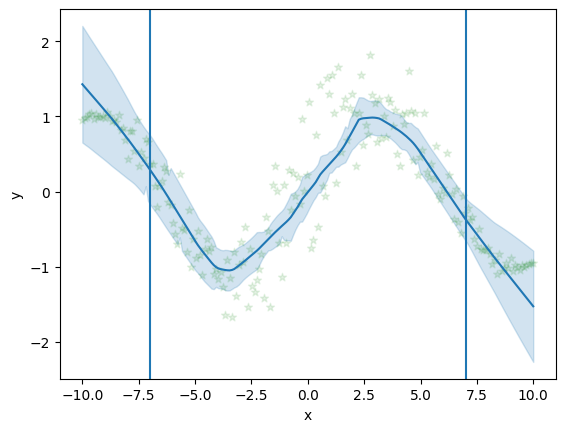

Epoch 149 | batch train loss: -0.8109673857688904 | test loss: 0.4084323206773171
Epoch 149 |batch train mse:0.1712031215429306| test mse:0.14814566878172067


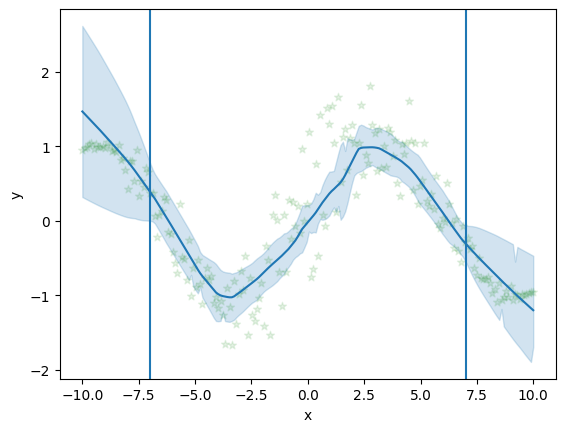

Epoch 149 | batch train loss: -1.1872631788253785 | test loss: 0.3746505357898199
Epoch 149 |batch train mse:0.05530024692416191| test mse:0.14732359578976265


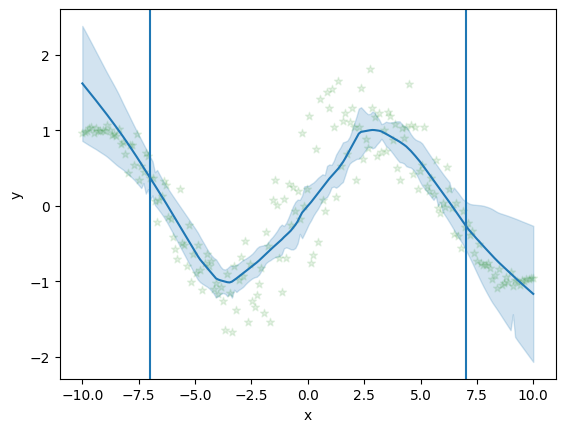

Epoch 149 | batch train loss: -1.2742218017578124 | test loss: 0.901445436019164
Epoch 149 |batch train mse:0.03964081406593323| test mse:0.16667811343303093


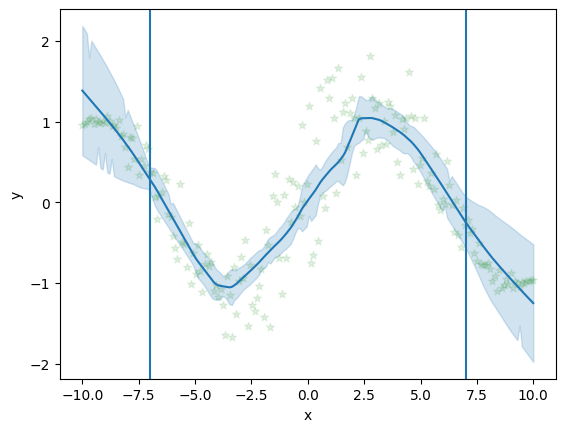

Epoch 149 | batch train loss: -1.1098986864089966 | test loss: 0.5213605295007044
Epoch 149 |batch train mse:0.036236703395843506| test mse:0.14580686333087775


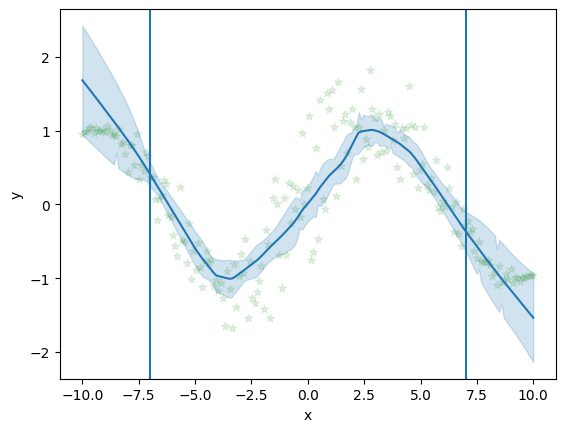

Epoch 149 | batch train loss: -1.1780311346054078 | test loss: 0.20212996739607592
Epoch 149 |batch train mse:0.052868302911520004| test mse:0.14248289683690438


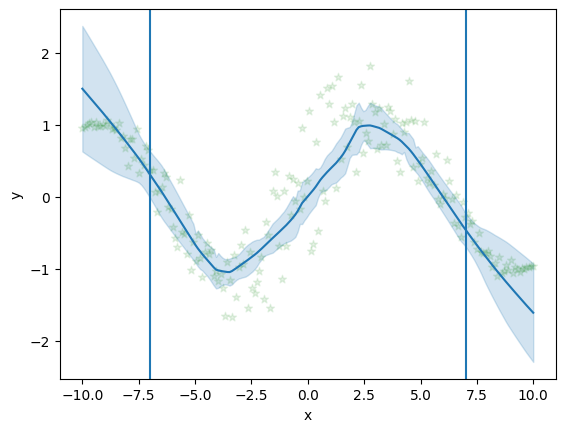

In [18]:
train_losses=[]
test_losses=[]
errors_train=[]
errors_test=[]
for i in range(10):
  tr_loss,test_loss,mse_tr,mse_test = denn()
  train_losses.append(tr_loss)
  test_losses.append(test_loss)
  errors_train.append(mse_tr)
  errors_test.append(mse_test)


Epoch 149 | batch train loss: -1.5619534492492675 | test loss: 0.3259546726942063
Epoch 149 |batch train mse:0.010511309839785099| test mse:0.07920921314507723


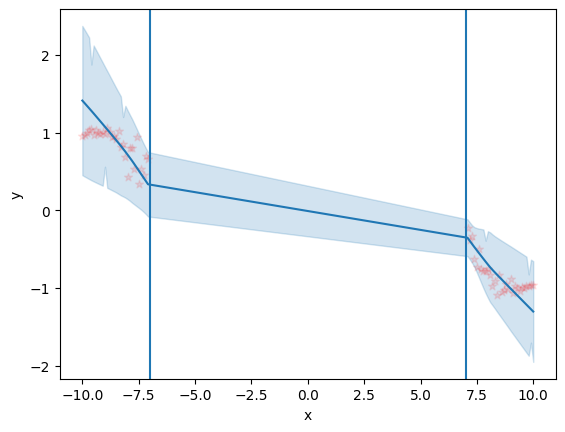

Epoch 149 | batch train loss: -1.2707173824310303 | test loss: 0.3038692698813975
Epoch 149 |batch train mse:0.03191148862242699| test mse:0.057431100867688656


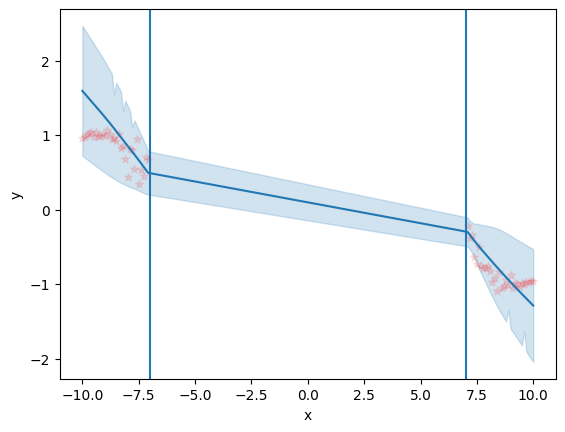

Epoch 149 | batch train loss: -1.2160038709640504 | test loss: 1.7917501863092185
Epoch 149 |batch train mse:0.07913455367088318| test mse:0.07323801051825285


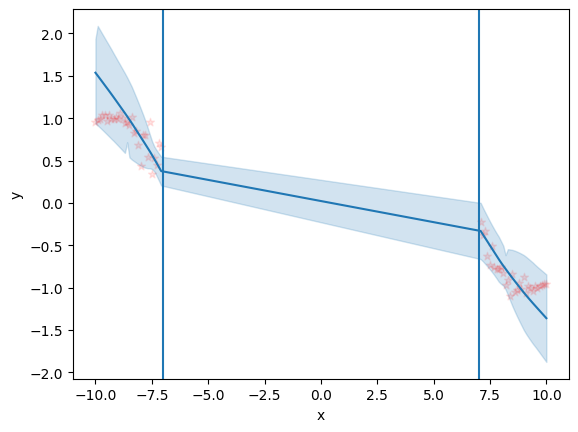

Epoch 149 | batch train loss: -1.0589775681495666 | test loss: 0.10778928548097609
Epoch 149 |batch train mse:0.0669844001531601| test mse:0.036528690718114376


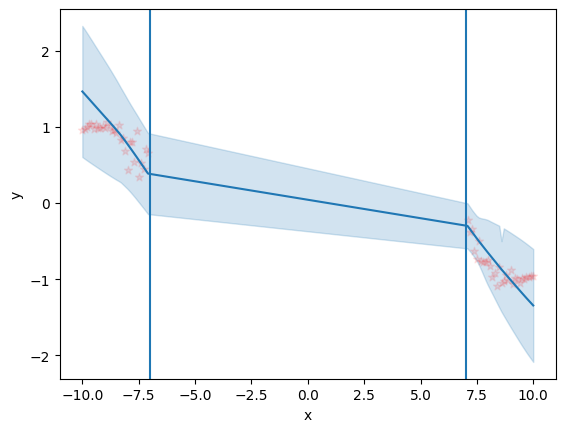

Epoch 149 | batch train loss: -1.1752194881439209 | test loss: 1.1352881595492366
Epoch 149 |batch train mse:0.05789703130722046| test mse:0.055678730364888906


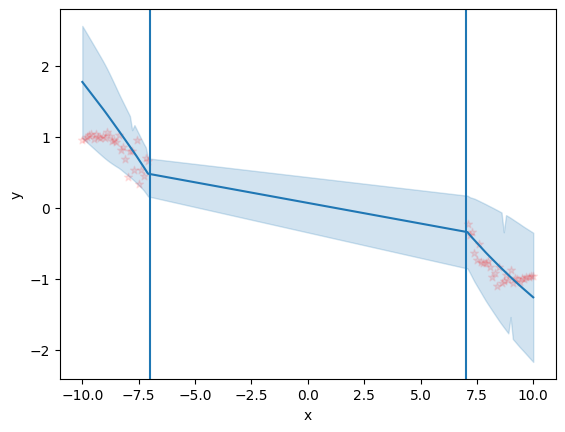

Epoch 149 | batch train loss: -1.2826424598693849 | test loss: 0.7379592237994075
Epoch 149 |batch train mse:0.015240860171616077| test mse:0.0430703591555357


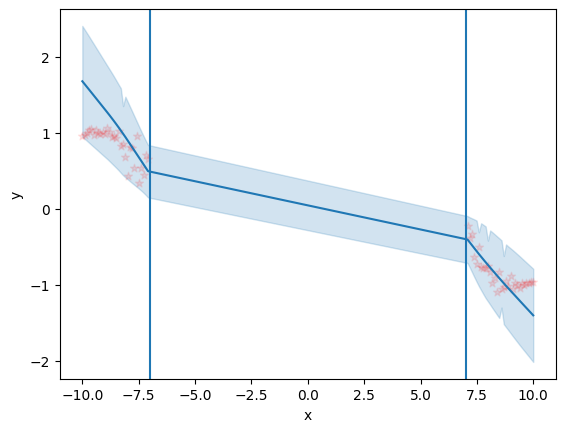

Epoch 149 | batch train loss: -1.0891026973724365 | test loss: 2.6235101722180842
Epoch 149 |batch train mse:0.06325794756412506| test mse:0.07269526179879904


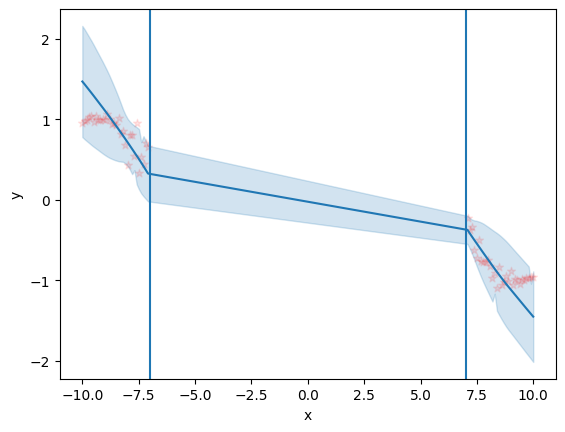

Epoch 149 | batch train loss: -0.8432506680488586 | test loss: 1.626131008565426
Epoch 149 |batch train mse:0.09594598412513733| test mse:0.0618462273851037


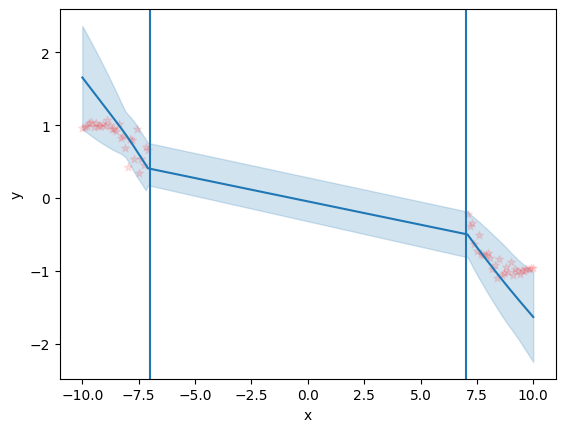

Epoch 149 | batch train loss: -0.9194743275642395 | test loss: 2.693455977737904
Epoch 149 |batch train mse:0.0663403570652008| test mse:0.05491624400019646


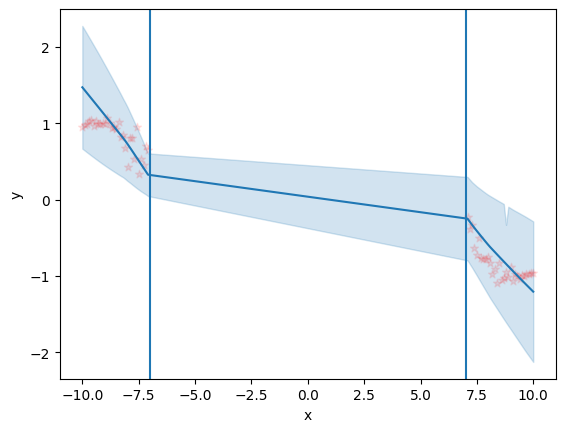

Epoch 149 | batch train loss: -1.2713650226593018 | test loss: 0.19628671854734422
Epoch 149 |batch train mse:0.03722690790891647| test mse:0.057528162375092506


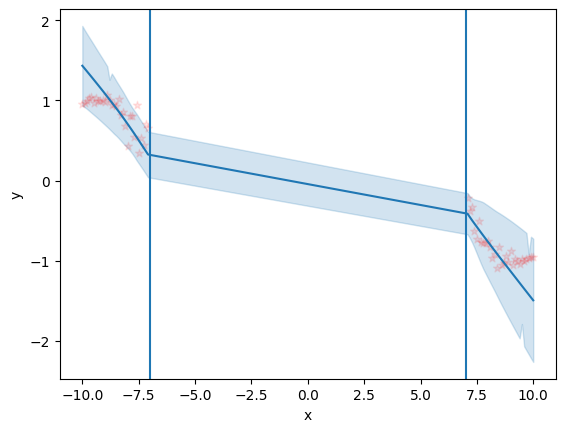

In [27]:
train_losses_oodd=[]
test_losses_oodd=[]
errors_train_oodd=[]
errors_test_oodd=[]
for i in range(10):
  tr_loss,test_loss,mse_tr,mse_test = denn_oodd()
  train_losses_oodd.append(tr_loss)
  test_losses_oodd.append(test_loss)
  errors_train_oodd.append(mse_tr)
  errors_test_oodd.append(mse_test)


Epoch 149 | batch train loss: -0.71144939661026 | test loss: 0.48380666673183437
Epoch 149 |batch train mse:0.09686500579118729| test mse:0.1947670073972808


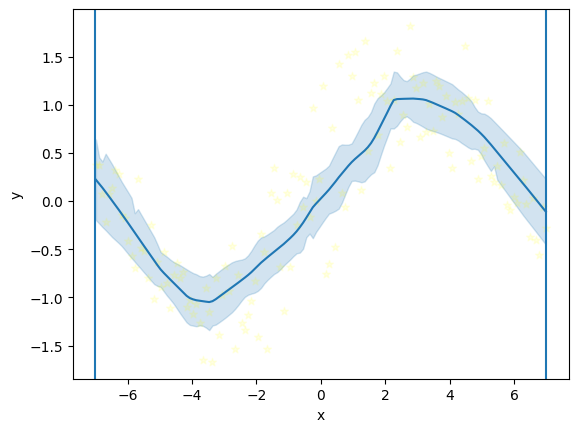

Epoch 149 | batch train loss: -0.9053848862648011 | test loss: 0.5617290450467003
Epoch 149 |batch train mse:0.08499520272016525| test mse:0.19294397036234537


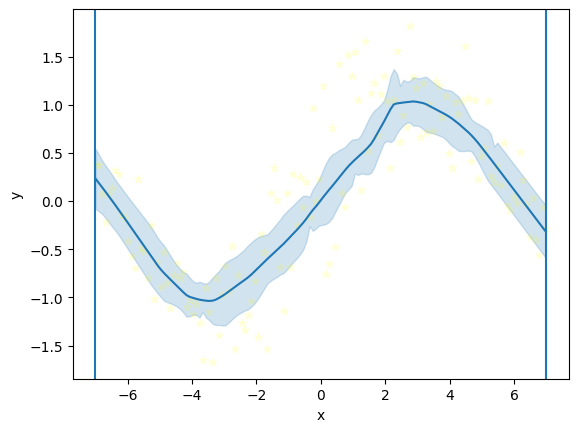

Epoch 149 | batch train loss: -1.0413691759109498 | test loss: 0.4656216743919585
Epoch 149 |batch train mse:0.1177639290690422| test mse:0.19478680855698055


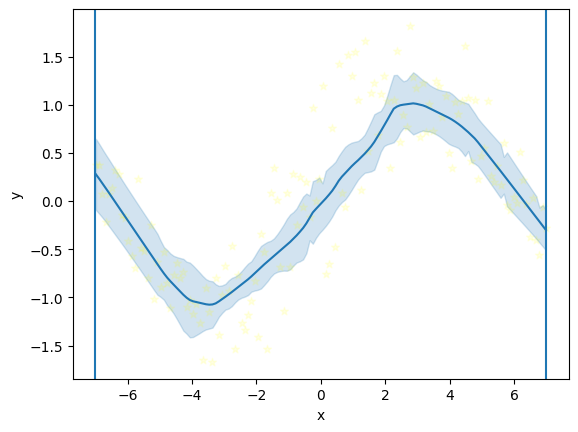

Epoch 149 | batch train loss: -0.8463938474655152 | test loss: 0.373622925289803
Epoch 149 |batch train mse:0.08790295571088791| test mse:0.19079611864354876


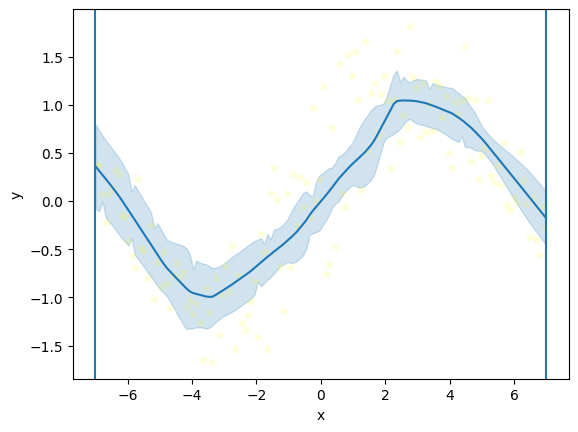

Epoch 149 | batch train loss: -1.0169248700141906 | test loss: 0.47282493876086334
Epoch 149 |batch train mse:0.045938923954963684| test mse:0.1903512395090527


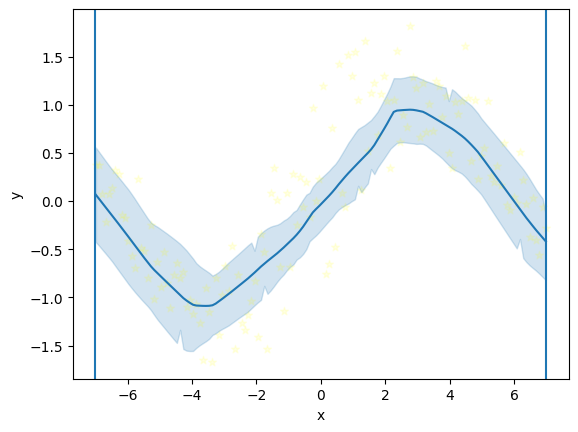

Epoch 149 | batch train loss: -0.9951228141784668 | test loss: 0.6054297215408749
Epoch 149 |batch train mse:0.06651373207569122| test mse:0.20113274455070496


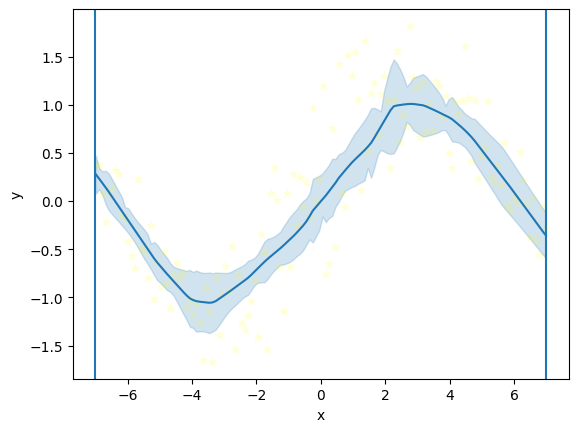

Epoch 149 | batch train loss: -1.4880277872085572 | test loss: 0.5074381028612454
Epoch 149 |batch train mse:0.02135074883699417| test mse:0.18983067489332622


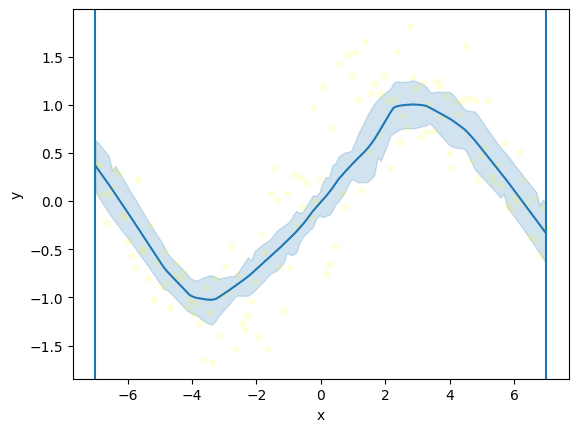

Epoch 149 | batch train loss: -1.1440864086151123 | test loss: 0.7437276069799231
Epoch 149 |batch train mse:0.05977502465248108| test mse:0.20418206188413832


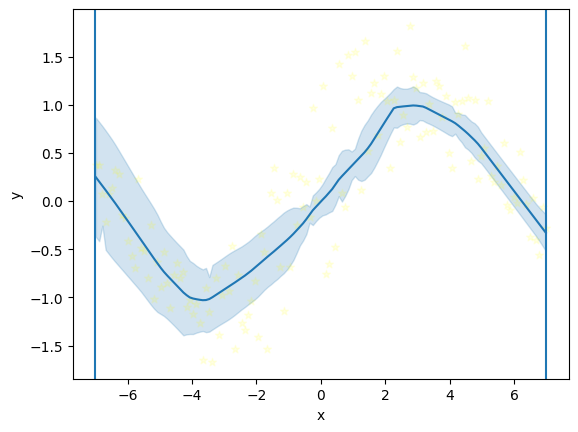

Epoch 149 | batch train loss: -0.9668952107429505 | test loss: 0.4947699795166652
Epoch 149 |batch train mse:0.08167804032564163| test mse:0.1996875587436888


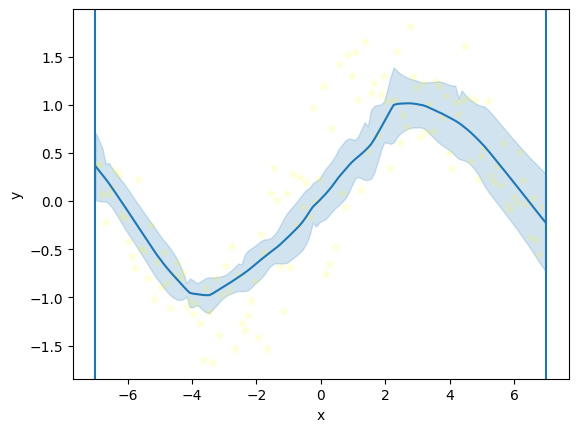

Epoch 149 | batch train loss: -1.0990872144699098 | test loss: 0.2844291320277585
Epoch 149 |batch train mse:0.07365642488002777| test mse:0.19386077092753518


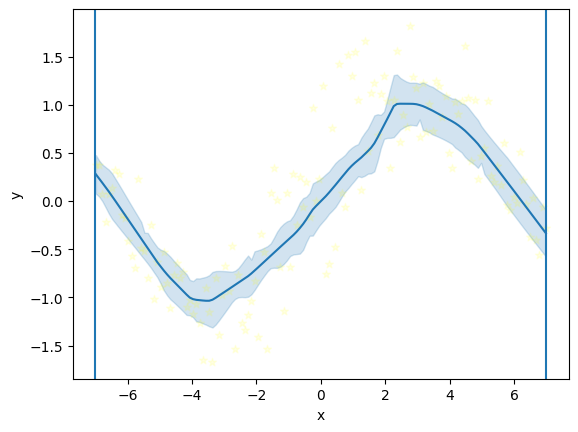

In [28]:
train_losses_idd=[]
test_losses_idd=[]
errors_train_idd=[]
errors_test_idd=[]
for i in range(10):
  tr_loss,test_loss,mse_tr,mse_test = denn_idd()
  train_losses_oodd.append(tr_loss)
  test_losses_oodd.append(test_loss)
  errors_train_oodd.append(mse_tr)
  errors_test_oodd.append(mse_test)


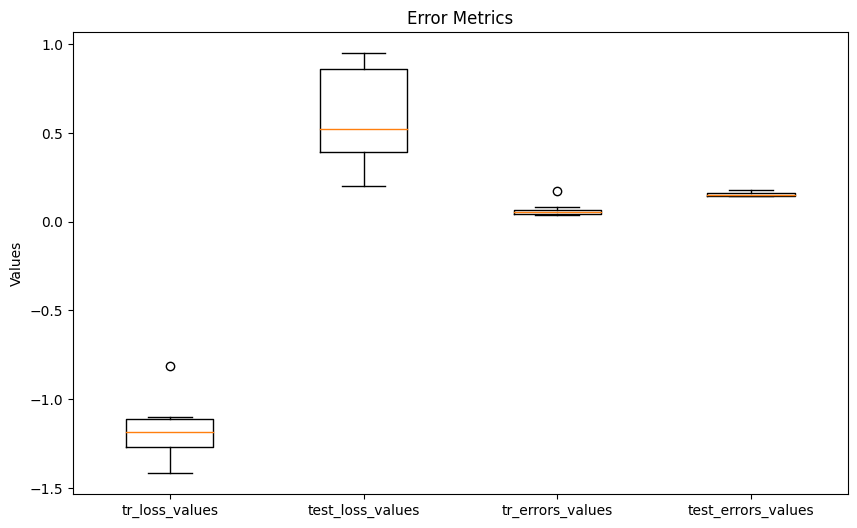

In [29]:
# Extract numerical values from the tensors and remove grad_fn
tr_loss_values= train_losses
test_loss_values=test_losses
tr_errors_values=  [tensor.item() for tensor in errors_train]
test_errors_values= errors_test

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create box plots for each dataset
box_plot_data = [tr_loss_values, test_loss_values, tr_errors_values, test_errors_values]
box_labels = ['tr_loss_values', 'test_loss_values', 'tr_errors_values', 'test_errors_values']

ax.boxplot(box_plot_data, labels=box_labels)

# Add labels and title

ax.set_ylabel('Values')
ax.set_title('Error Metrics')

# Show the plot
plt.show()



In [30]:

mean_gaus_train_loss = np.mean(tr_loss_values)
std_dev_gaus_train_loss = np.std(tr_loss_values)

mean_gaus_test_loss = np.mean(test_loss_values)
std_dev_gaus_test_loss = np.std(test_loss_values)

mean_mse_train = np.mean(tr_errors_values)
std_dev_mse_train = np.std(tr_errors_values)

mean_mse_test = np.mean(test_errors_values)
std_dev_mse_test = np.std(test_errors_values)

print('Mean of Gausiann Training Loss of 10 runs ', mean_gaus_train_loss)
print('Standard Deviation of Gausiann Training Loss of 10 runs ' , std_dev_gaus_train_loss )

print('Mean of Gausiann Testing Loss of 10 runs ',mean_gaus_test_loss )
print('Standard Deviation of Gausiann Testing Loss of 10 runs ',std_dev_gaus_test_loss)

print('Mean of MSE Training of 10 runs ',mean_mse_train)
print('Standard Deviation of MSE Training of 10 runs ' , std_dev_mse_train)

print('Mean of MSE Testing of 10 runs ',mean_mse_test )
print('Standard Deviation of MSE Testing of 10 runs ', std_dev_mse_test)

Mean of Gausiann Training Loss of 10 runs  -1.183335577249527
Standard Deviation of Gausiann Training Loss of 10 runs  0.16030563971217318
Mean of Gausiann Testing Loss of 10 runs  0.5946822795787682
Standard Deviation of Gausiann Testing Loss of 10 runs  0.25578034004389993
Mean of MSE Training of 10 runs  0.06389780528843403
Standard Deviation of MSE Training of 10 runs  0.03823481209007804
Mean of MSE Testing of 10 runs  0.15469582628172177
Standard Deviation of MSE Testing of 10 runs  0.011408201674795488


In [31]:
# Create a DataFrame from the lists
data = {
    'Training Loss': tr_loss_values,
    'Testing Loss': test_loss_values,
    'Mean Squared Training Error': tr_errors_values,
    'Mean Squared Testing Error': test_errors_values
}

num_columns = len(data)

column_names = ['Training Loss','Testing Loss', 'Mean Squared Training Error','Mean Squared Testing Error']

# Create a DataFrame with dynamic column names
df = pd.DataFrame(data, columns=column_names)
df.index += 1
# Display the DataFrame as a table
print(df)
df.to_csv('results_de.csv', index=True)

    Training Loss  Testing Loss  Mean Squared Training Error  \
1       -1.370844      0.949071                     0.050988   
2       -1.416288      0.945914                     0.038445   
3       -1.102800      0.384550                     0.070749   
4       -1.126031      0.734519                     0.080280   
5       -1.257010      0.524749                     0.043266   
6       -0.810967      0.408432                     0.171203   
7       -1.187263      0.374651                     0.055300   
8       -1.274222      0.901445                     0.039641   
9       -1.109899      0.521361                     0.036237   
10      -1.178031      0.202130                     0.052868   

    Mean Squared Testing Error  
1                     0.159995  
2                     0.160558  
3                     0.144489  
4                     0.180264  
5                     0.151216  
6                     0.148146  
7                     0.147324  
8                     0.166678 

In [32]:
print(test_errors_values)

[0.15999457927850577, 0.16055839909957006, 0.1444887054654268, 0.18026391989909685, 0.15121552090232188, 0.14814566878172067, 0.14732359578976265, 0.16667811343303093, 0.14580686333087775, 0.14248289683690438]
